### 定义 Vector2

`Vector2` 表示坐标系里的一个点。
实现坐标点乘。

In [45]:
data class Vector2(val x: Double, val y: Double) {
    operator fun times(other: Vector2): Double {
        return this.x * other.x + this.y * other.y;
    }
}

// 测试
Vector2(1.0, 2.0) * Vector2(2.0, 1.0)

4.0

# 先实现生成 500 * 500 的灰度图



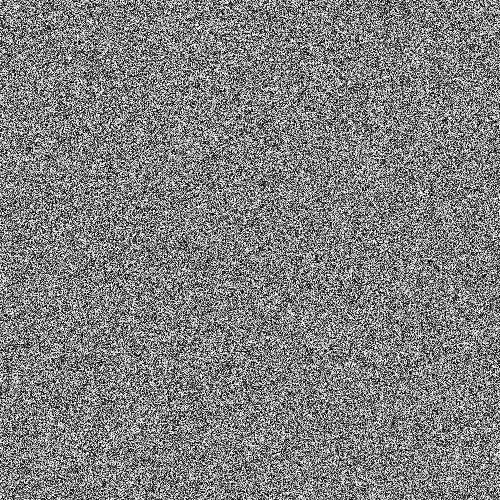

In [46]:
import java.awt.Color
import java.awt.image.BufferedImage
import java.io.ByteArrayOutputStream
import kotlin.random.Random
import java.io.IOException
import java.net.URL


val width: Int = 500;
val height: Int = 500;

val image = BufferedImage(width, height, BufferedImage.TYPE_INT_ARGB)

for (y in 0 until height) {
    for (x in 0 until width) {
        // 生成一个 0 到 255 之间的随机灰度值
        val grayValue = Random.nextInt(0, 256)
        // 设置像素的颜色
        image.setRGB(x, y, Color(grayValue, grayValue, grayValue).rgb)
    }
}

image

### 生成 `permutation table`

<https://cs.nyu.edu/~perlin/noise/> 

示例：
```js
[
   151,160,137,91,90,15,
   131,13,201,95,96,53,194,233,7,225,140,36,103,30,69,142,8,99,37,240,21,10,23,
   190, 6,148,247,120,234,75,0,26,197,62,94,252,219,203,117,35,11,32,57,177,33,
   88,237,149,56,87,174,20,125,136,171,168, 68,175,74,165,71,134,139,48,27,166,
   77,146,158,231,83,111,229,122,60,211,133,230,220,105,92,41,55,46,245,40,244,
   102,143,54, 65,25,63,161, 1,216,80,73,209,76,132,187,208, 89,18,169,200,196,
   135,130,116,188,159,86,164,100,109,198,173,186, 3,64,52,217,226,250,124,123,
   5,202,38,147,118,126,255,82,85,212,207,206,59,227,47,16,58,17,182,189,28,42,
   223,183,170,213,119,248,152, 2,44,154,163, 70,221,153,101,155,167, 43,172,9,
   129,22,39,253, 19,98,108,110,79,113,224,232,178,185, 112,104,218,246,97,228,
   251,34,242,193,238,210,144,12,191,179,162,241, 81,51,145,235,249,14,239,107,
   49,192,214, 31,181,199,106,157,184, 84,204,176,115,121,50,45,127, 4,150,254,
   138,236,205,93,222,114,67,29,24,72,243,141,128,195,78,66,215,61,156,180
]
```

In [47]:
fun createPermutationTable(): List<Int> {
    val list = MutableList<Int>(256) { it }
    val list2 =  list.shuffled()
    return (list2 + list2)
}

val P = createPermutationTable()

### 展示 permutation table

In [48]:
%use kandy(0.7.0)

import org.jetbrains.kotlinx.kandy.util.color.Color as KColor

val permutationData:  Map<String, List<Int>>  = mapOf(
    "index" to     (1..512).toList(),
    "permutation" to P,
);

plot(permutationData) {
    x("index")
    y("permutation")


    points {
        color = KColor.RED
        symbol = Symbol.CIRCLE
        size = 2.5
    }

    line {
        color = KColor.BLUE
    }
}

### 展示 permutation table

直接 permutation table 转为灰度图

(x,y) 取值公式是：`V = P[ P[x] + y ]`。

会在 P 上的点，会跳一次。先取到 `x` 位置的值 V<sub>x</sub>，V<sub>x</sub> + y 位置的值 `V<sub>x2<sub>`。（x,y)对应的值就是 `V<sub>x2<sub>`

假设有 `P = [3,2,1,4, 232, ... ]`
    
（2, 1) 坐标对应的值就是 `P[ P[2] + 1 ]` ==> `P[ 1 + 1 ]` ==>  `P[ 2 ]` ==> `4`

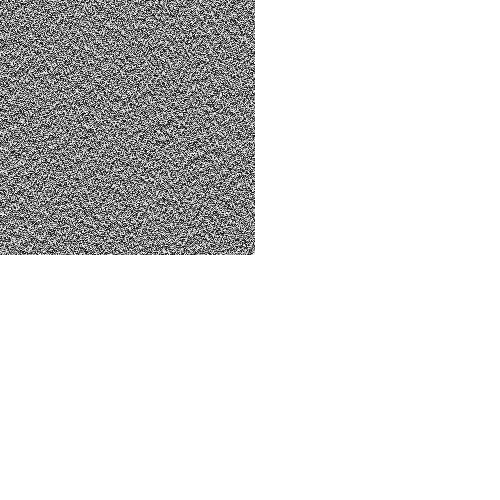

In [49]:
val pImage = BufferedImage(width, height, BufferedImage.TYPE_INT_ARGB)

for (y in 0 until 255) {
    for (x in 0 until 255) {
        // 生成一个 0 到 255 之间的随机灰度值
        val grayValue = P[ P[x] + y ]
        // 设置像素的颜色
        pImage.setRGB(x, y, Color(grayValue, grayValue, grayValue).rgb)
    }
}

pImage

In [50]:
// 获取常数向量
fun GetConstantVector(v: Int): Vector2 {
    // v is the value from the permutation table
    val h = v and 3;
    return when(h) {
        0 -> Vector2(1.0, 1.0)
        1 -> Vector2(-1.0, 1.0);
        2 -> Vector2(-1.0, -1.0)
        else -> Vector2(1.0, -1.0)
    }
}

In [51]:
val xStart = mutableListOf<Int>()
val yStart = mutableListOf<Int>()
val xEnd = mutableListOf<Int>()
val yEnd = mutableListOf<Int>()
val vPoints = mutableListOf<Int>()

for (y in 0 until 20) {
    for (x in 0 until 20) {
        xStart.add(x)
        yStart.add(y)
        vPoints.add(P[P[x] + y] % 4)
//         val vector = GetConstantVector();
//         xEnd.add(x + vector.x.toInt())
//         yEnd.add(y + vector.y.toInt())
    }
}

val gridMap = mapOf(
    "xStart" to xStart,
    "yStart" to yStart,
    "vPoints" to vPoints,
)

plot(gridMap) {
    points  {
        x("xStart")
        y("yStart")
        color("vPoints")
    }
}

### 平滑曲线辅助函数


### 编写 Noise2d_v1 函数

In [52]:
fun Fade(t: Double): Double {
    return ((6*t - 15)*t + 10)*t*t*t;
}

fun Lerp(t: Double, a1: Double, a2: Double): Double {
    return a1 + t*(a2-a1);
}

// 差值 Lerp
val x: List<Double> = (0..100).step(1).map { it.toDouble() / 100.0 }
val y: List<Double> = x.map { Fade(it) }
val curveMap = mapOf("x" to x, "y" to y)

plot(curveMap) {
    x("x")
    y("y")
    line {
        color = KColor.GREEN
    }
}

In [53]:
fun Noise2d_v1(x: Double, y: Double): Double {
    val X = Math.round(x).toInt() and 255 // 等价于取余 256
    val Y =  Math.round(y).toInt() and 255 // 等价于取余 256

    // decimal place
    val X_f = x - Math.round(x)
    val Y_f = y - Math.round(y)
    
    val topRight = Vector2(X_f - 1.0, Y_f - 1.0);
    val topLeft =  Vector2(X_f, Y_f - 1.0);
    val bottomRight = Vector2(X_f - 1.0, Y_f);
    val bottomLeft = Vector2(X_f, Y_f);

    val valueTopRight = P[P[X + 1] + Y + 1];
    val valueTopLeft = P[P[X] + Y + 1];
    val valueBottomRight = P[P[X + 1] + Y];
    val valueBottomLeft = P[P[X] + Y];
    
    val dotTopRight = topRight * GetConstantVector(valueTopRight)
    val dotTopLeft = topLeft * GetConstantVector(valueTopLeft)
    val dotBottomRight = bottomRight * GetConstantVector(valueBottomRight)
    val dotBottomLeft = bottomLeft * GetConstantVector(valueBottomLeft)

    val u = Fade(X_f);
    val v = Fade(Y_f);
    return Lerp(
        u,
        Lerp(v, dotBottomLeft, dotTopLeft),
        Lerp(v, dotBottomRight, dotTopRight)
    );
}

Noise2d_v1(100.5, 100.5)

-52.359375

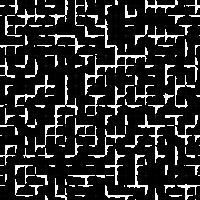

In [60]:
import java.awt.Color

val height= 200
val width = 200
val image_v1 = BufferedImage(width, height, BufferedImage.TYPE_INT_ARGB)
for (y in 0 until height) {
    for (x in 0 until width) {
        // 生成一个 0 到 255 之间的随机灰度值
        val value = Noise2d_v1(x * 0.1, y * 0.1)
   
        val grayValue = value.toInt() and 255
        // 设置像素的颜色
        image_v1.setRGB(x, y, Color(grayValue, grayValue, grayValue).rgb)
    }
}

image_v1